In [153]:
import pandas as pd

In [154]:
titanic = pd.read_csv("Titanic-Dataset.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Titanic-Dataset.csv'

In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
titanic.head()

In [ ]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [156]:
# Know the proportions of the feature class
class_proportions_df = pd.DataFrame({
    "count": titanic["Survived"].value_counts(),
    "ratio": titanic["Survived"].value_counts() / titanic["Survived"].count()
})

class_proportions_df



,count,ratio
Survived,,
0,549,0.616162
1,342,0.383838


In [ ]:
# Feature Engineering
from sklearn.preprocessing import LabelEncoder

titanic_tree = titanic.copy()
# Removing columns that will not help in the prediction, they are too unique
titanic_tree = titanic_tree.drop(["PassengerId","Name", "Ticket", "Fare"], axis=1)

# Encoding
label_encoder = LabelEncoder()
titanic_tree["Sex_encoded"] = label_encoder.fit_transform(titanic_tree["Sex"])
titanic_tree["Cabin_encoded"] = label_encoder.fit_transform(titanic_tree["Cabin"])
titanic_tree["Embarked_encoded"] = label_encoder.fit_transform(titanic_tree["Embarked"])
titanic_tree = titanic_tree.drop(["Sex", "Cabin", "Embarked"], axis=1)
titanic_tree

,Survived,Pclass,Age,SibSp,Parch,Sex_encoded,Cabin_encoded,Embarked_encoded
0,0,3,22.0,1,0,1,147,2
1,1,1,38.0,1,0,0,81,0
2,1,3,26.0,0,0,0,147,2
3,1,1,35.0,1,0,0,55,2
4,0,3,35.0,0,0,1,147,2
...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,1,147,2
887,1,1,19.0,0,0,0,30,2
888,0,3,NaN,1,2,0,147,2
889,1,1,26.0,0,0,1,60,0


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
X = titanic_tree.drop(["Survived"], axis=1)

# Handle missing values in age here
imputer = IterativeImputer(random_state=1)
imputed = imputer.fit_transform(X)

X_imputed = pd.DataFrame(imputed, columns=X.columns)
y = titanic_tree["Survived"]

# Splitting  train and test data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.7, stratify=y, random_state=1)

In [ ]:
X_imputed.isnull().sum()

Pclass              0
Age                 0
SibSp               0
Parch               0
Sex_encoded         0
Cabin_encoded       0
Embarked_encoded    0
dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7772435897435898

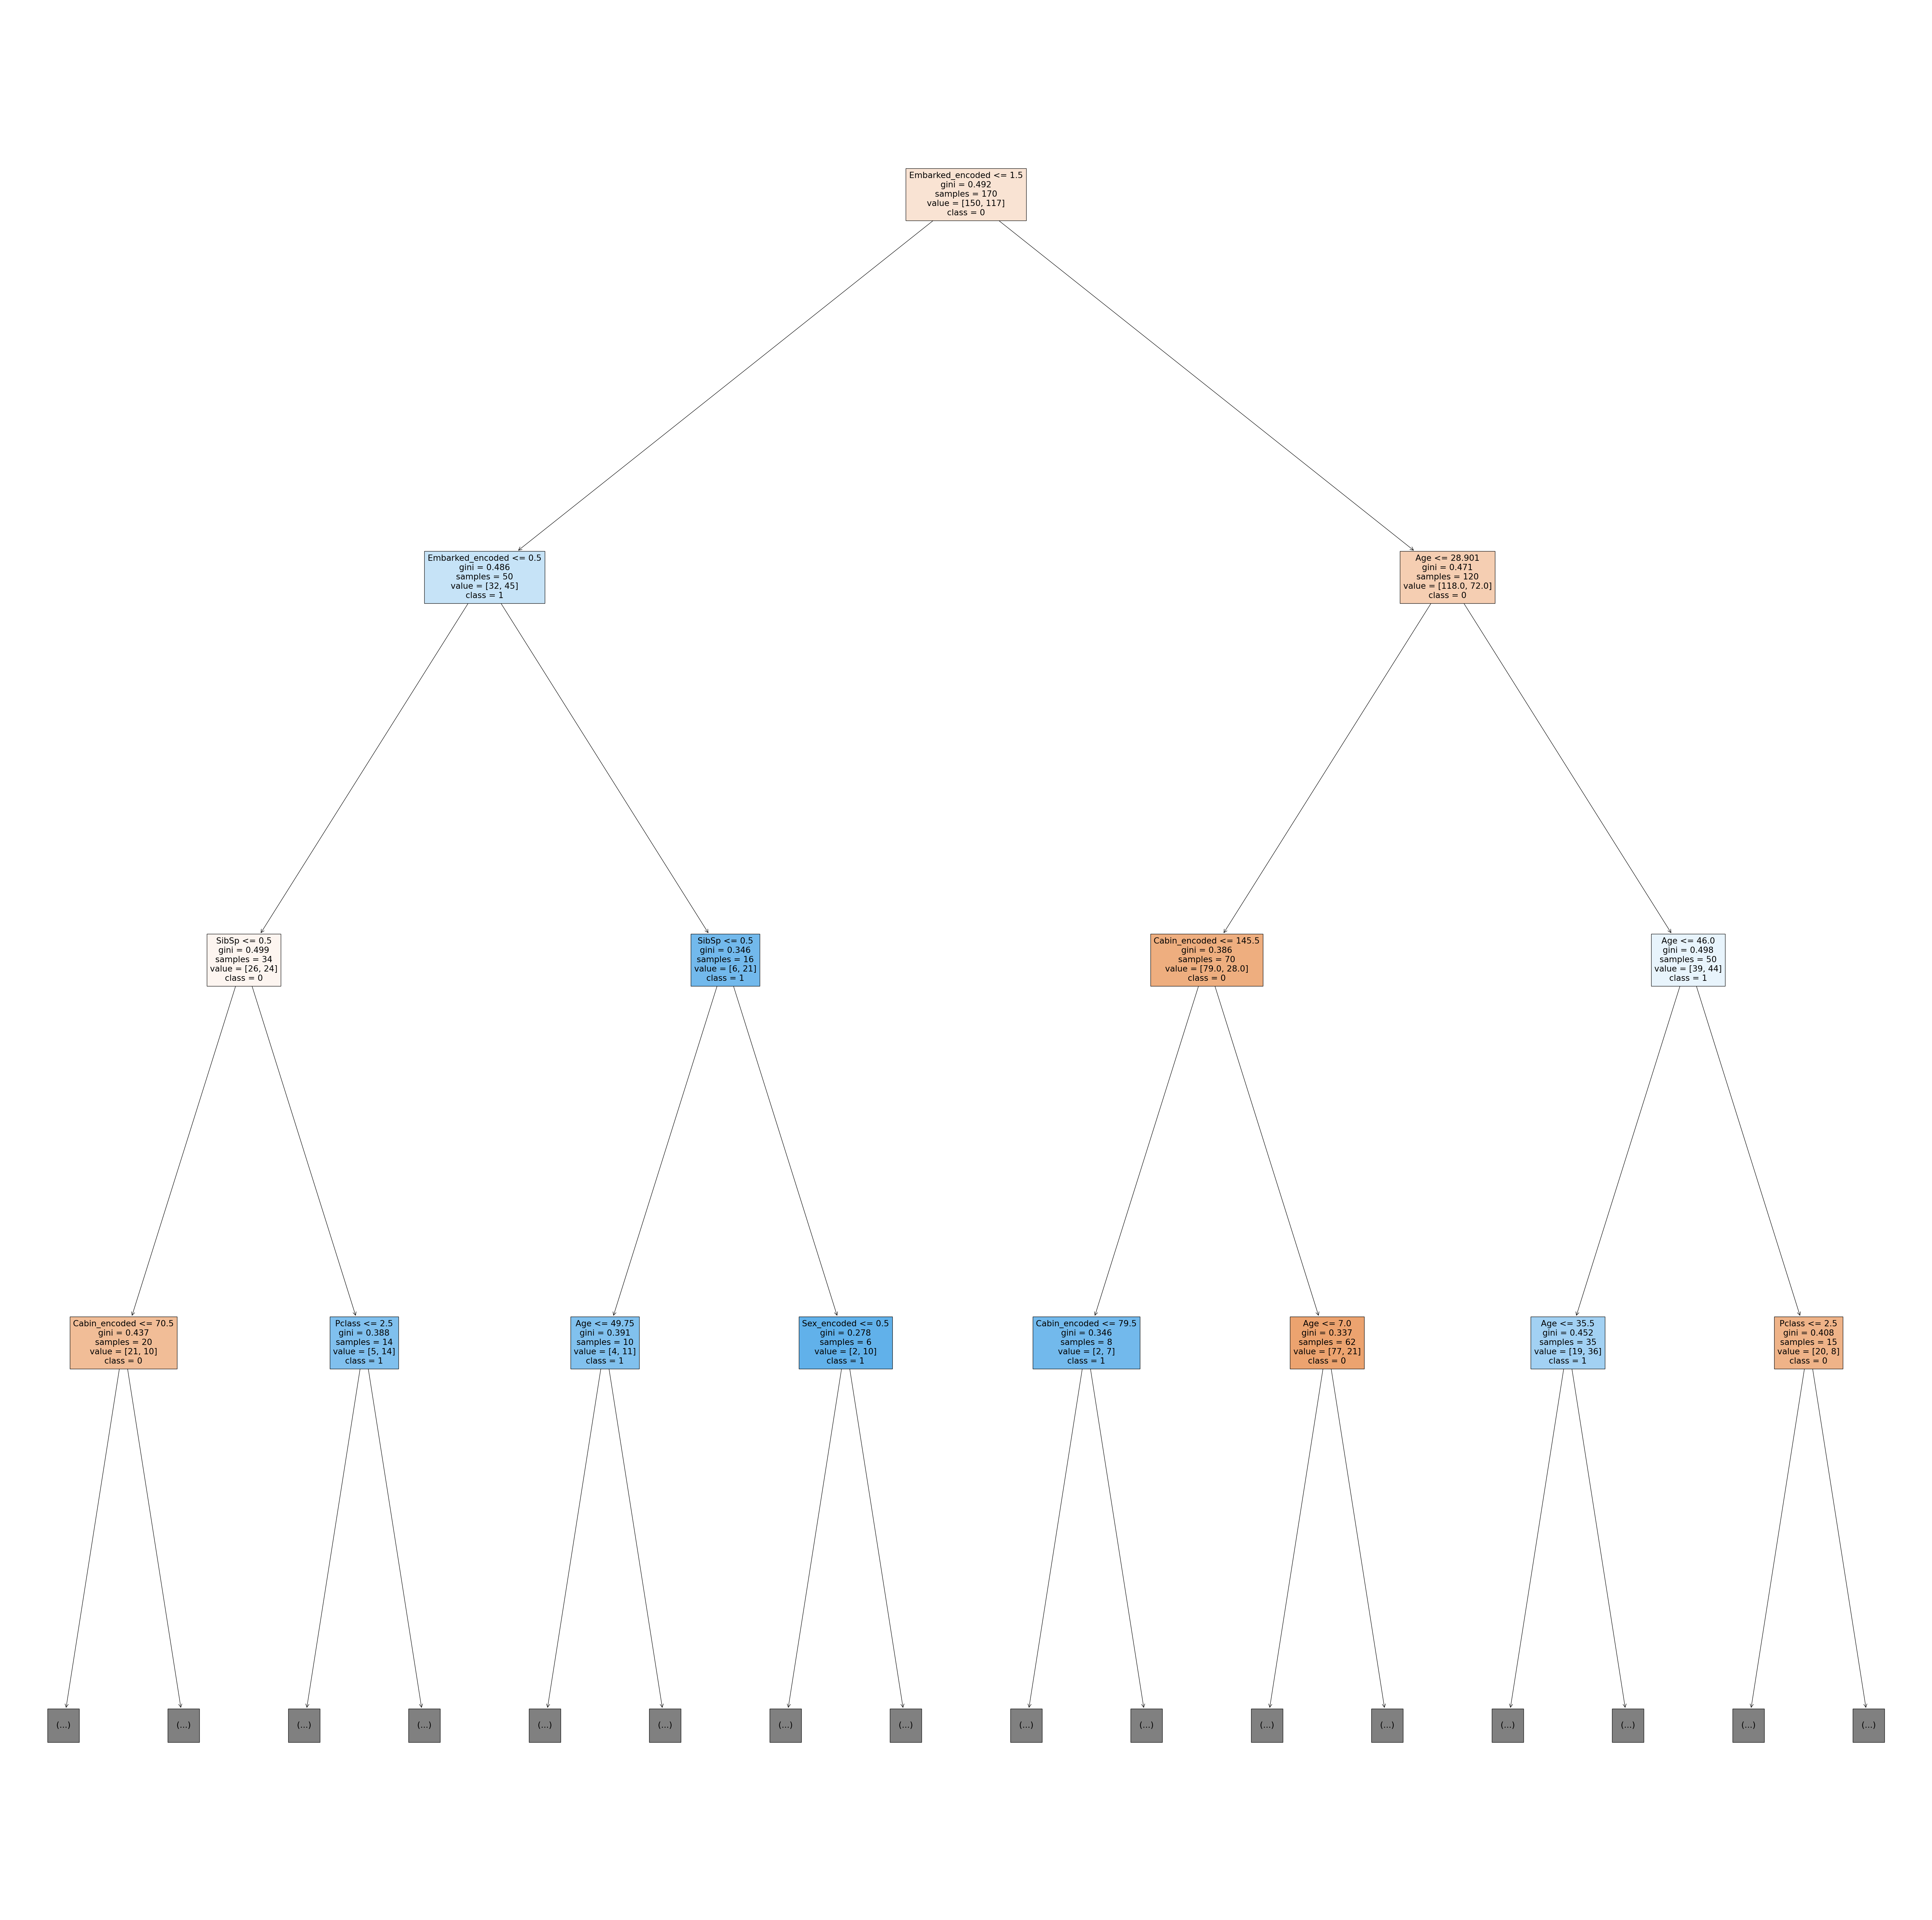

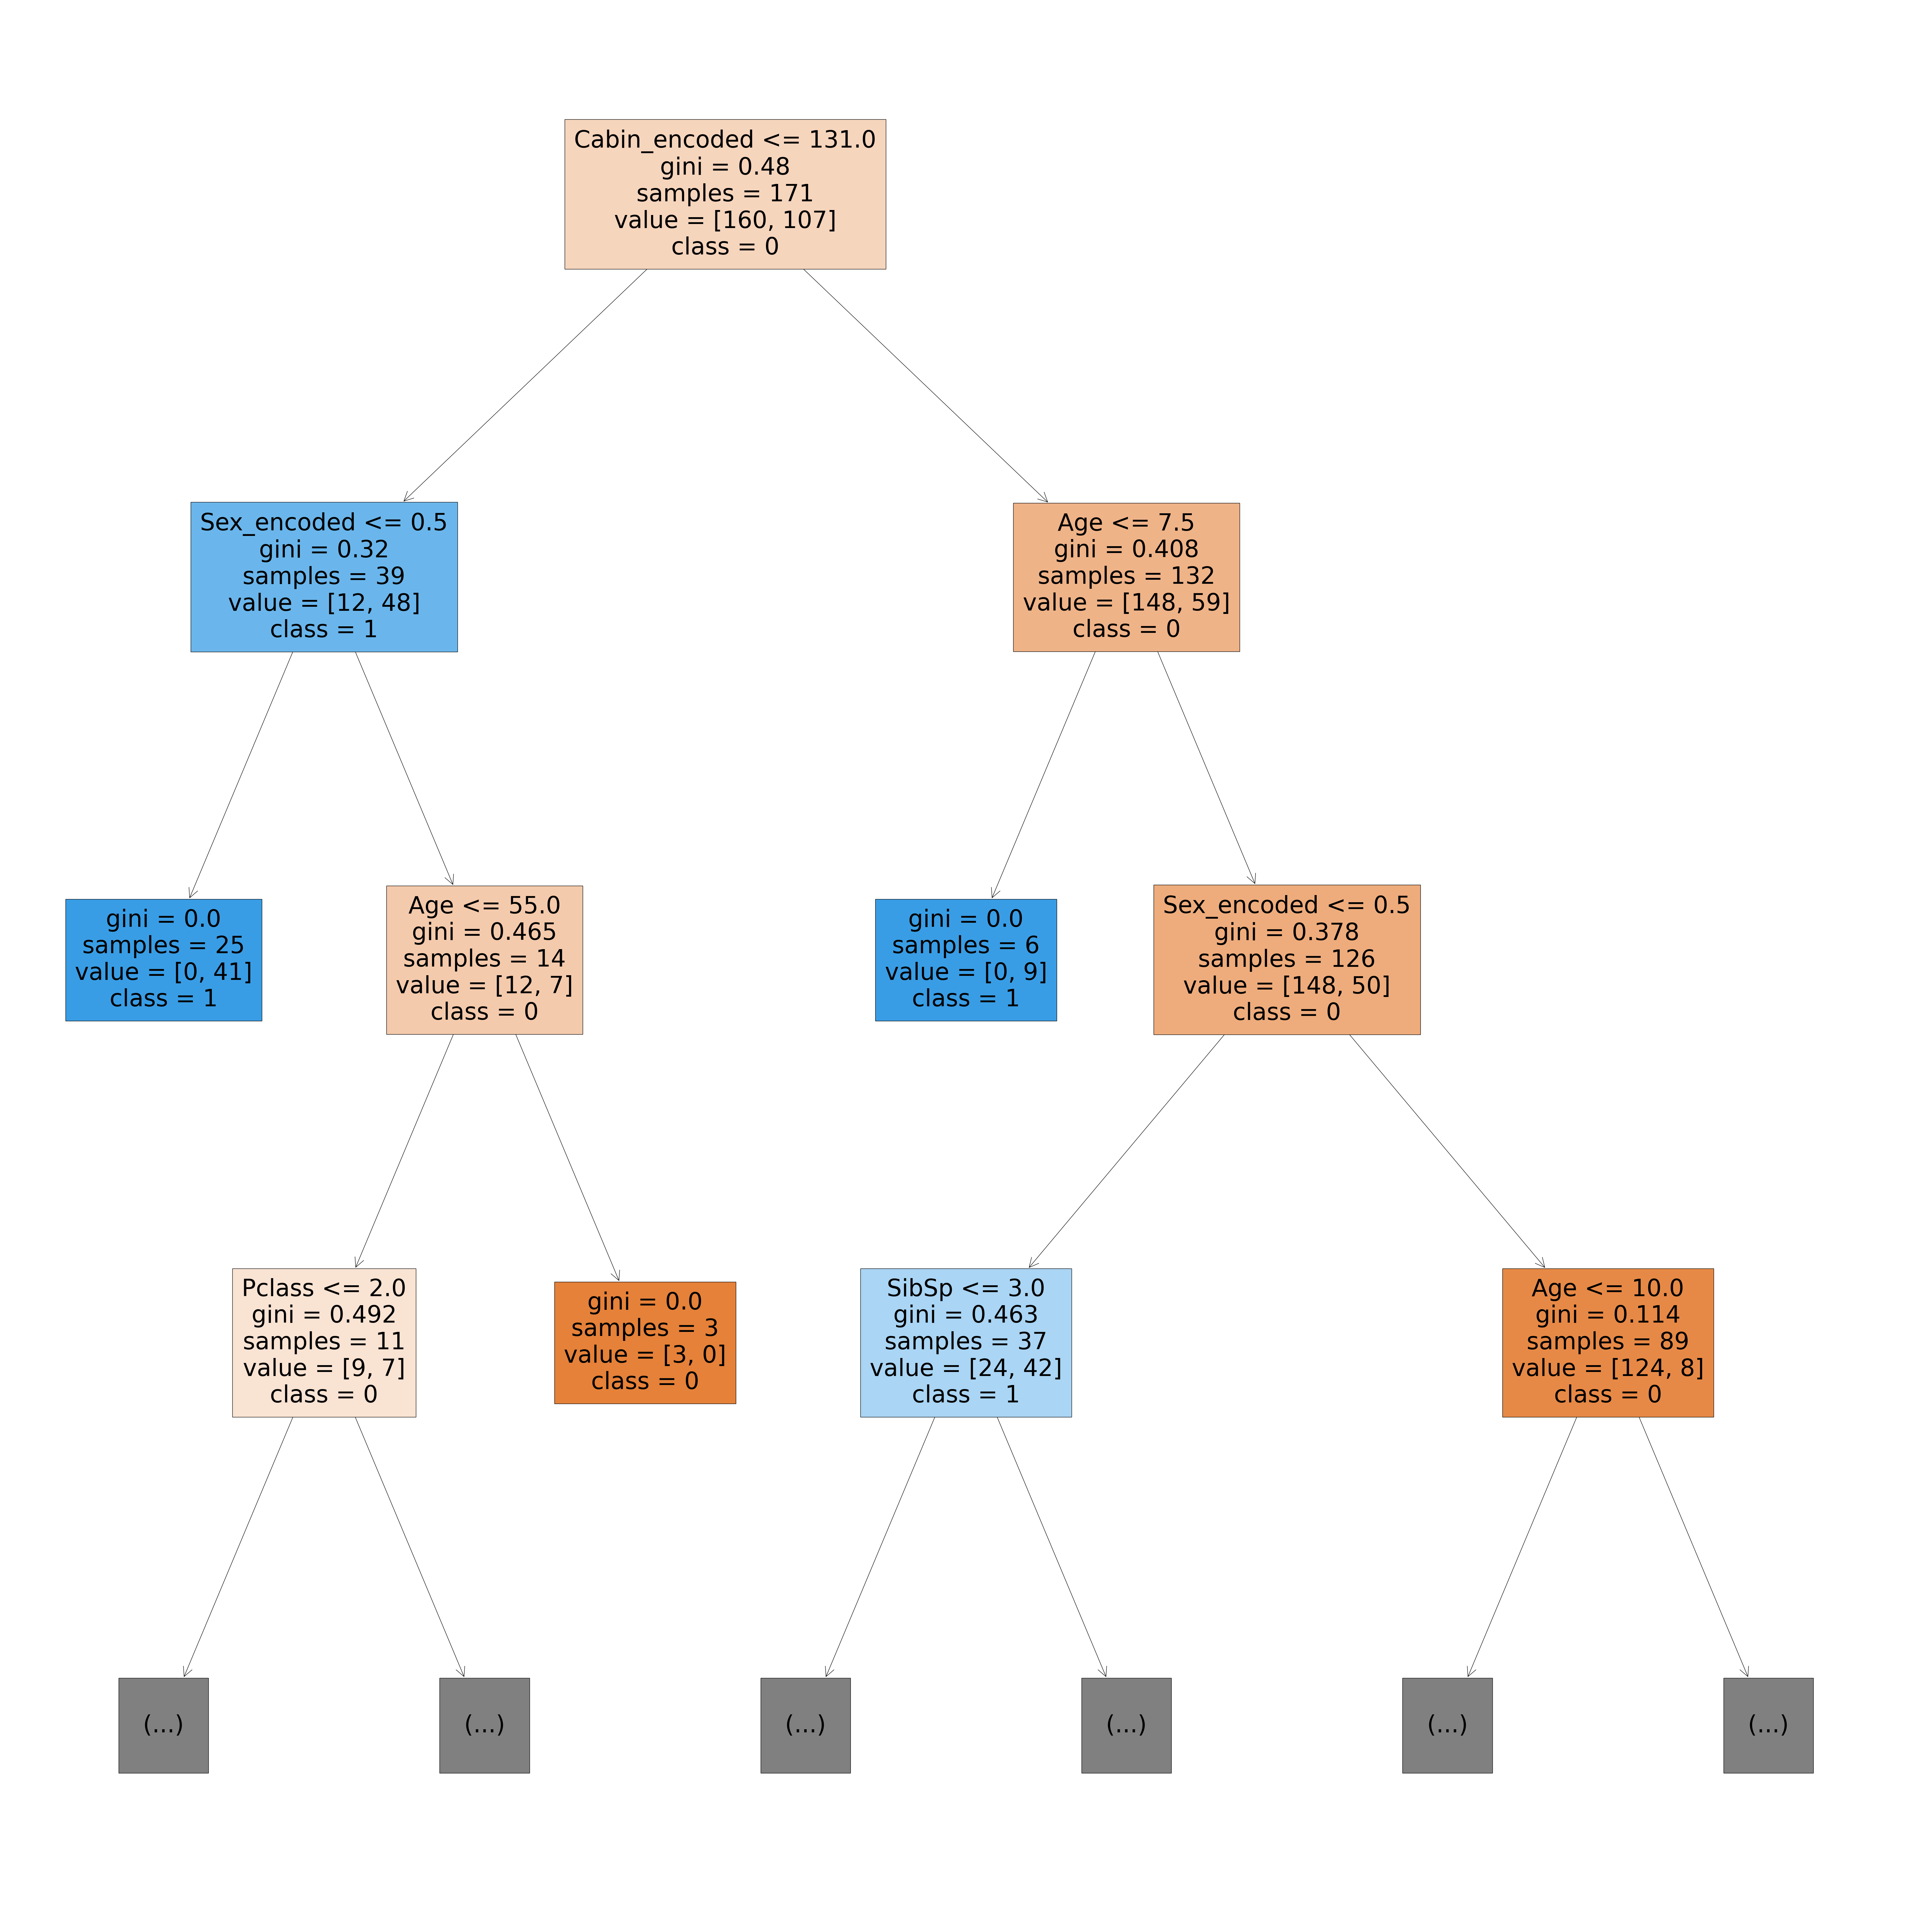

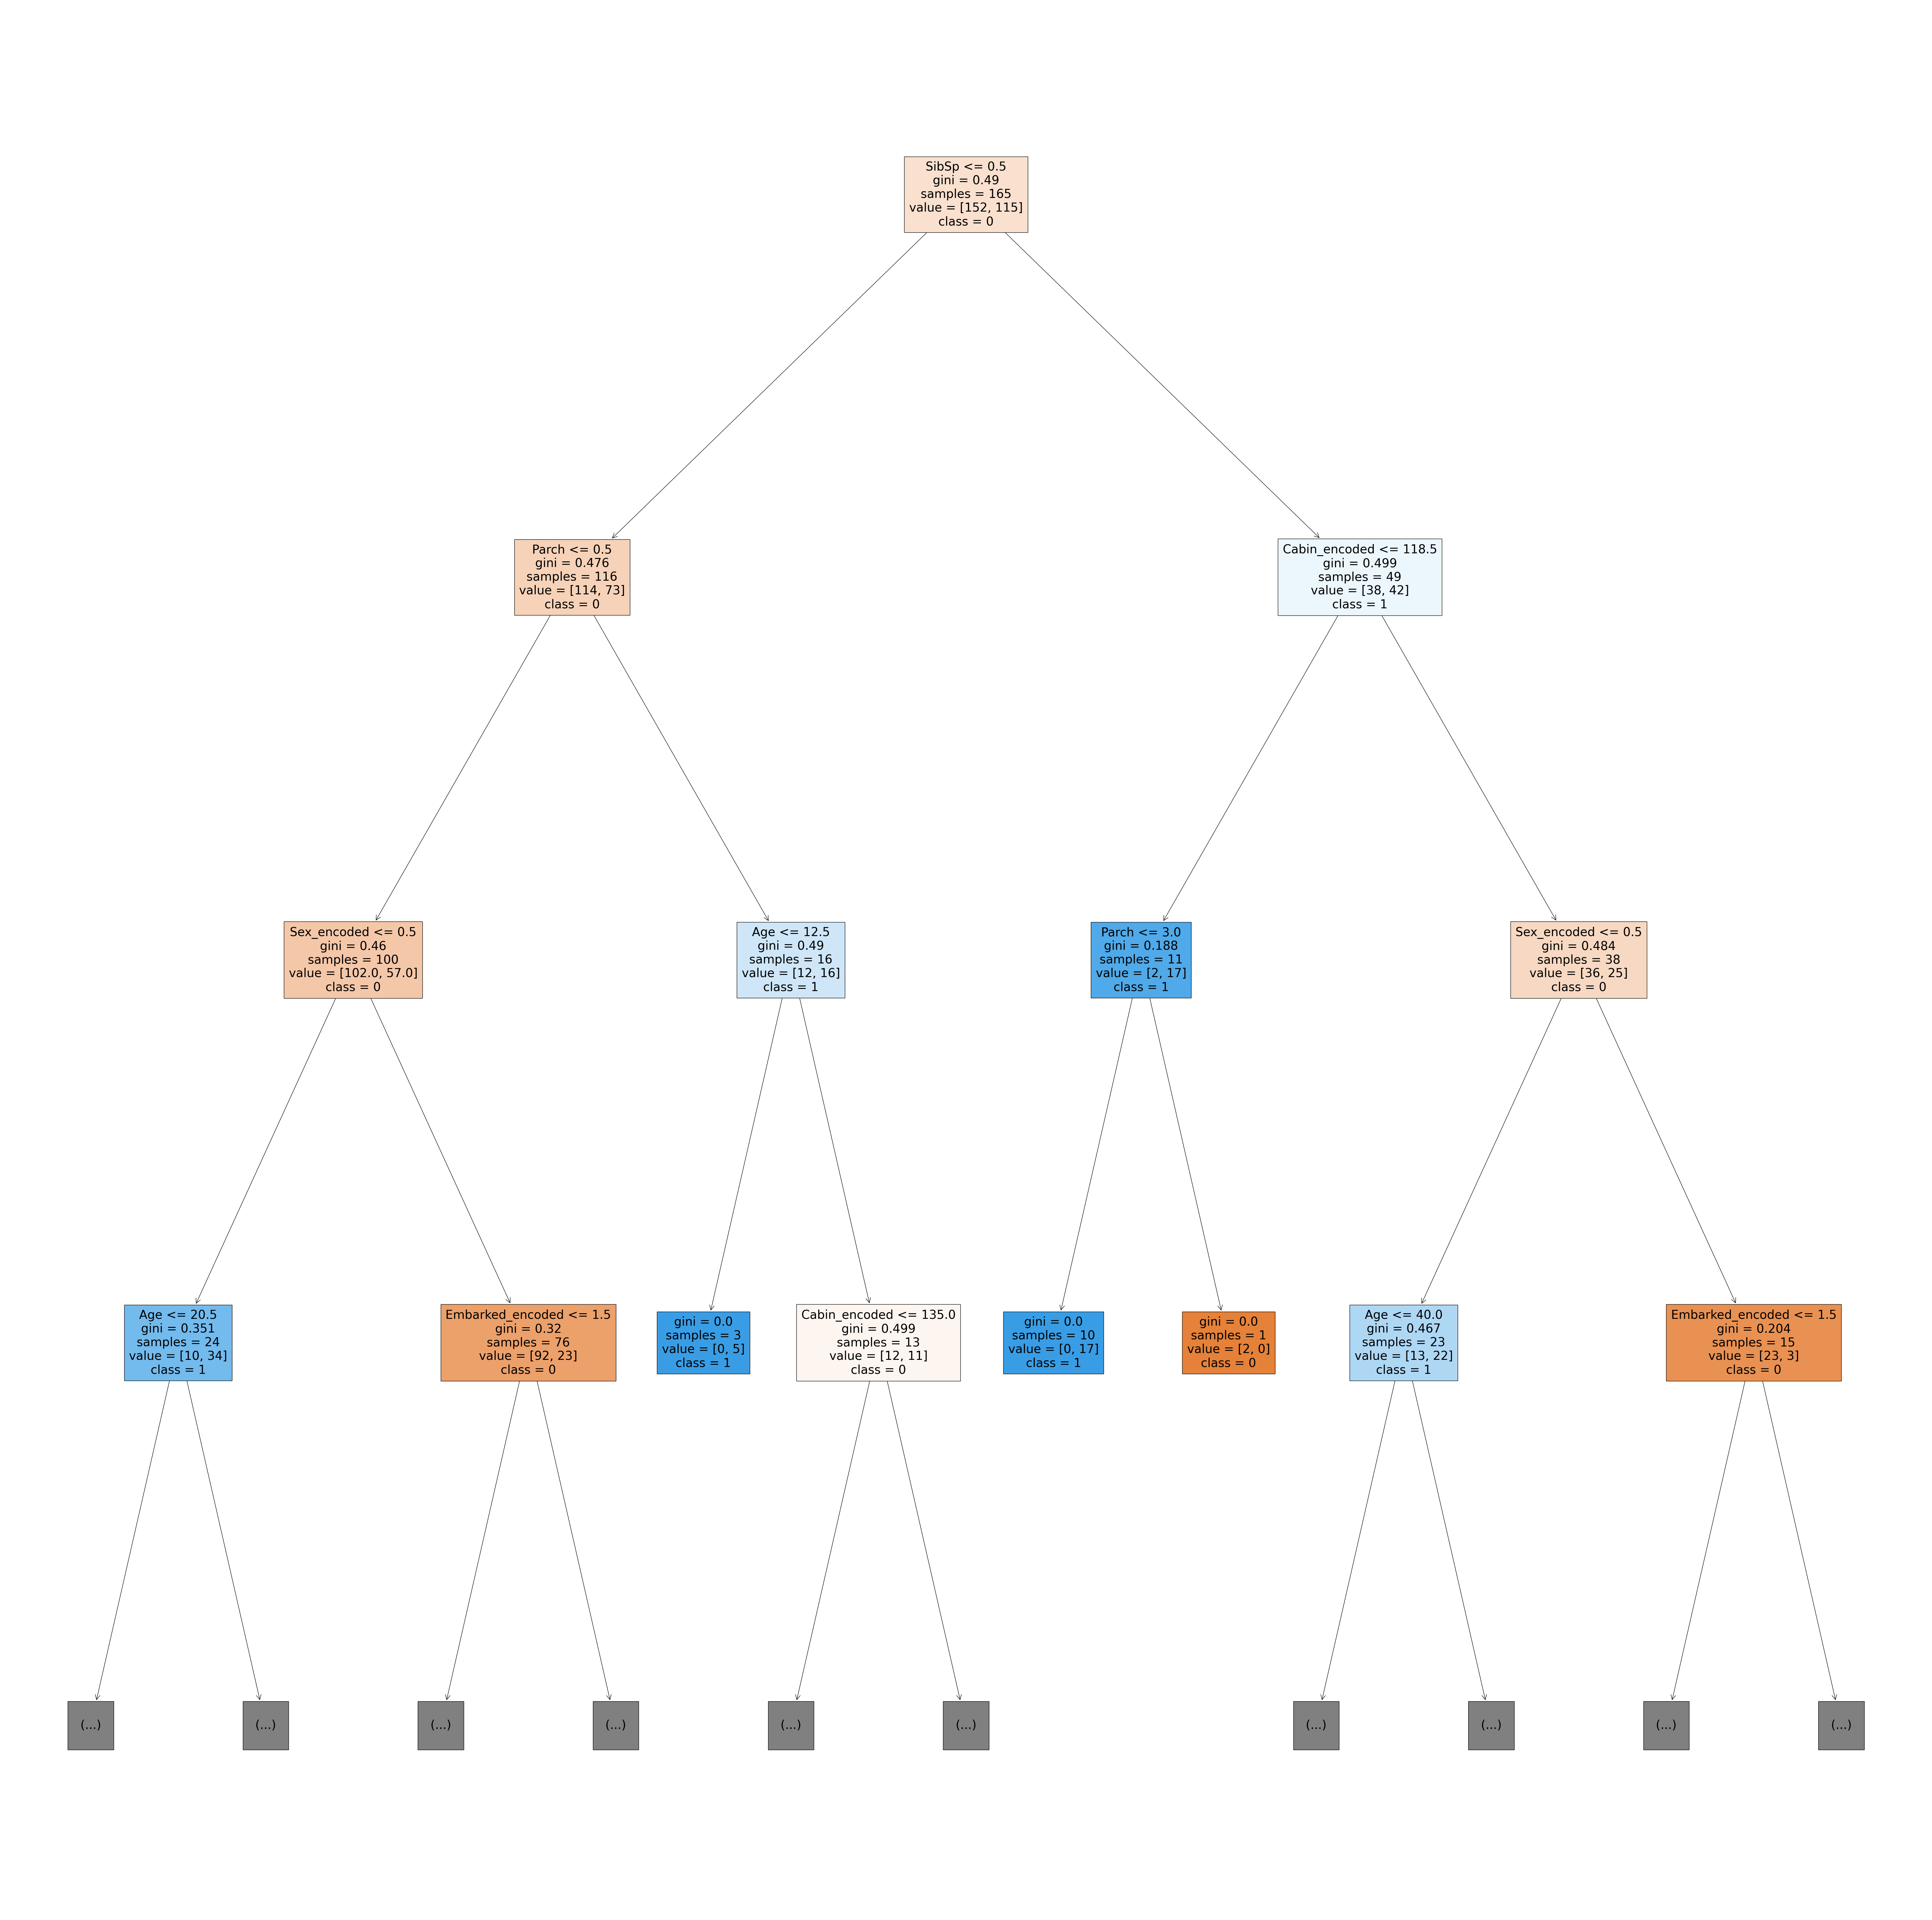

In [ ]:
# Draw first 3 decision trees in the random forest
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

for i in range(3):
    tree = rf.estimators_[i]
    plt.figure(figsize=(80,80))
    plot_tree(
        tree,
        feature_names=X_imputed.columns,
        class_names=[str(x) for x in y.unique()],
        filled=True,
        max_depth=3
        )
    plt.show()

In [ ]:
# Hyperparameter finetuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

parameters =  {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20)
    }
random_search = RandomizedSearchCV(
    rf,
    param_distributions=parameters,
    n_iter=10,
    cv=5
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

random_search.best_params_



{'max_depth': 6, 'n_estimators': 114}

In [ ]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8205128205128205